<a href="https://colab.research.google.com/github/Kaancnkya/Data-Science-with-python-notebooks/blob/main/car_data_tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Normalization

# version check
print("TensorFlow version:", tf.__version__)

plt.style.use('seaborn-v0_8')

TensorFlow version: 2.19.0


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [ ]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [ ]:
feature_names = [
    'symboling','normalized-losses','make','fuel-type','aspiration','num-doors',
    'body-style','drive-wheels','engine-location','wheel-base','length','width',
    'height','weight','engine-type','num-cylinders','engine-size','fuel-system',
    'bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price'
]

car_data = pd.read_csv(
    'https://storage.googleapis.com/mledu-datasets/cars_data.csv',
    sep=',', names=feature_names, header=None, encoding='latin-1'
)

# shuffle the datas
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Dataset loaded successfully.")
print("Total examples:", len(car_data))
car_data.head()

Dataset loaded successfully.
Total examples: 205


,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
144,0,102,subaru,gas,std,four,sedan,4wd,front,97.00,...,108,2bbl,3.62,2.64,9.00,82,4800,24,25,9233
82,3,?,mitsubishi,gas,turbo,two,hatchback,fwd,front,95.90,...,156,spdi,3.58,3.86,7.00,145,5000,19,24,12629
74,1,?,mercedes-benz,gas,std,two,hardtop,rwd,front,112.00,...,304,mpfi,3.80,3.35,8.00,184,4500,14,16,45400
52,1,104,mazda,gas,std,two,hatchback,fwd,front,93.10,...,91,2bbl,3.03,3.15,9.00,68,5000,31,38,6795
157,0,91,toyota,gas,std,four,hatchback,fwd,front,95.70,...,98,2bbl,3.19,3.03,9.00,70,4800,30,37,7198


# This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [ ]:
# Preview of the dataset
print("Preview of the dataset:")
display(car_data.head(7))

# General information (data types, non-null count, memory usage)
print("\nDataset information:")
car_data.info()

# Missing value check
print("\nMissing values per column:")
display(car_data.isnull().sum())

Preview of the dataset:


,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
144,0,102,subaru,gas,std,four,sedan,4wd,front,97.00,...,108,2bbl,3.62,2.64,9.00,82,4800,24,25,9233
82,3,?,mitsubishi,gas,turbo,two,hatchback,fwd,front,95.90,...,156,spdi,3.58,3.86,7.00,145,5000,19,24,12629
74,1,?,mercedes-benz,gas,std,two,hardtop,rwd,front,112.00,...,304,mpfi,3.80,3.35,8.00,184,4500,14,16,45400
52,1,104,mazda,gas,std,two,hatchback,fwd,front,93.10,...,91,2bbl,3.03,3.15,9.00,68,5000,31,38,6795
157,0,91,toyota,gas,std,four,hatchback,fwd,front,95.70,...,98,2bbl,3.19,3.03,9.00,70,4800,30,37,7198
53,1,113,mazda,gas,std,four,sedan,fwd,front,93.10,...,91,2bbl,3.03,3.15,9.00,68,5000,31,38,6695
133,2,104,saab,gas,std,four,sedan,fwd,front,99.10,...,121,mpfi,3.54,3.07,9.30,110,5250,21,28,12170



Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 144 to 170
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-doors          205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  weight             205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-cylinders      205 non-null    object 
 16  engine-

,0
symboling,0
normalized-losses,0
make,0
fuel-type,0
aspiration,0
...,...
horsepower,0
peak-rpm,0
city-mpg,0
highway-mpg,0


In [ ]:
# Define the label
LABEL = 'price'

# Separate features (numeric and categorical)
numeric_feature_names = [
    'symboling', 'normalized-losses', 'wheel-base', 'engine-size',
    'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm',
    'city-mpg', 'highway-mpg', 'length', 'width', 'height', 'weight'
]

categorical_feature_names = list(
    set(car_data.columns) - set(numeric_feature_names) - set([LABEL])
)

# Statistical summary for numeric columns
print("\nStatistical summary (numeric features):")
display(car_data[numeric_feature_names].describe())

# Summary of results
print("\nNumeric feature count:", len(numeric_feature_names))
print("Categorical feature count:", len(categorical_feature_names))
print("\nNumeric features:", numeric_feature_names)
print("Categorical features:", categorical_feature_names)


Statistical summary (numeric features):


,symboling,wheel-base,engine-size,compression-ratio,city-mpg,highway-mpg,length,width,height,weight
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,126.91,10.14,25.22,30.75,174.05,65.91,53.72,2555.57
std,1.25,6.02,41.64,3.97,6.54,6.89,12.34,2.15,2.44,520.68
min,-2.00,86.60,61.00,7.00,13.00,16.00,141.10,60.30,47.80,1488.00
25%,0.00,94.50,97.00,8.60,19.00,25.00,166.30,64.10,52.00,2145.00
50%,1.00,97.00,120.00,9.00,24.00,30.00,173.20,65.50,54.10,2414.00
75%,2.00,102.40,141.00,9.40,30.00,34.00,183.10,66.90,55.50,2935.00
max,3.00,120.90,326.00,23.00,49.00,54.00,208.10,72.30,59.80,4066.00



Numeric feature count: 15
Categorical feature count: 10

Numeric features: ['symboling', 'normalized-losses', 'wheel-base', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'length', 'width', 'height', 'weight']
Categorical features: ['fuel-system', 'num-doors', 'engine-location', 'body-style', 'aspiration', 'num-cylinders', 'drive-wheels', 'engine-type', 'make', 'fuel-type']


In [ ]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [ ]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,length,width,height,weight
144,0,102,97.00,108,3.62,2.64,9.00,82,4800,24,25,172.00,65.40,54.30,2385
82,3,?,95.90,156,3.58,3.86,7.00,145,5000,19,24,173.20,66.30,50.20,2833
74,1,?,112.00,304,3.80,3.35,8.00,184,4500,14,16,199.20,72.00,55.40,3715
52,1,104,93.10,91,3.03,3.15,9.00,68,5000,31,38,159.10,64.20,54.10,1905
157,0,91,95.70,98,3.19,3.03,9.00,70,4800,30,37,166.30,64.40,52.80,2109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2,94,97.30,97,3.01,3.40,23.00,68,4500,37,42,171.70,65.50,55.70,2319
55,3,150,95.30,70,?,?,9.40,101,6000,17,23,169.00,65.70,49.60,2380
26,1,148,93.70,90,2.97,3.23,9.40,68,5500,31,38,157.30,63.80,50.60,1989
184,2,94,97.30,97,3.01,3.40,23.00,52,4800,37,46,171.70,65.50,55.70,2264


In [ ]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,fuel-system,num-doors,engine-location,body-style,aspiration,num-cylinders,drive-wheels,engine-type,make,fuel-type
144,2bbl,four,front,sedan,std,four,4wd,ohcf,subaru,gas
82,spdi,two,front,hatchback,turbo,four,fwd,ohc,mitsubishi,gas
74,mpfi,two,front,hardtop,std,eight,rwd,ohcv,mercedes-benz,gas
52,2bbl,two,front,hatchback,std,four,fwd,ohc,mazda,gas
157,2bbl,four,front,hatchback,std,four,fwd,ohc,toyota,gas
...,...,...,...,...,...,...,...,...,...,...
187,idi,four,front,sedan,turbo,four,fwd,ohc,volkswagen,diesel
55,4bbl,two,front,hatchback,std,two,rwd,rotor,mazda,gas
26,2bbl,four,front,sedan,std,four,fwd,ohc,dodge,gas
184,idi,four,front,sedan,std,four,fwd,ohc,volkswagen,diesel


In [ ]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

X = car_data[numeric_feature_names].values
y = car_data[LABEL].values

# Train-test split (%80 train, %20 test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert all sets to float32 tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

#attempt 1

# Our model creation
model_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # regression: only one output
])

# compiling the model
model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
) #setting the weights

# model training
history_1 = model_1.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)

# consider on test sets
loss_1, mae_1 = model_1.evaluate(X_test, y_test)
print(f"Test MSE: {loss_1:.2f}, MAE: {mae_1:.2f}")



Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 213925360.0000 - mae: 11996.0303 - val_loss: 77028528.0000 - val_mae: 5600.8203
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 89892640.0000 - mae: 6929.8921 - val_loss: 67042660.0000 - val_mae: 6617.9009
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 72230880.0000 - mae: 6657.0732 - val_loss: 66798064.0000 - val_mae: 5104.0352
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 59601360.0000 - mae: 5320.9390 - val_loss: 55811668.0000 - val_mae: 5912.8379
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63131320.0000 - mae: 5667.1045 - val_loss: 54835996.0000 - val_mae: 4450.5142
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 49224580.0000 - mae: 4813.8037 - val_loss: 46315932.0000 - val_mae: 5103.4023
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 61196324.0000 - mae: 5771.9180 - val_loss: 42372748.0000 - val_mae: 4302.6587
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 45

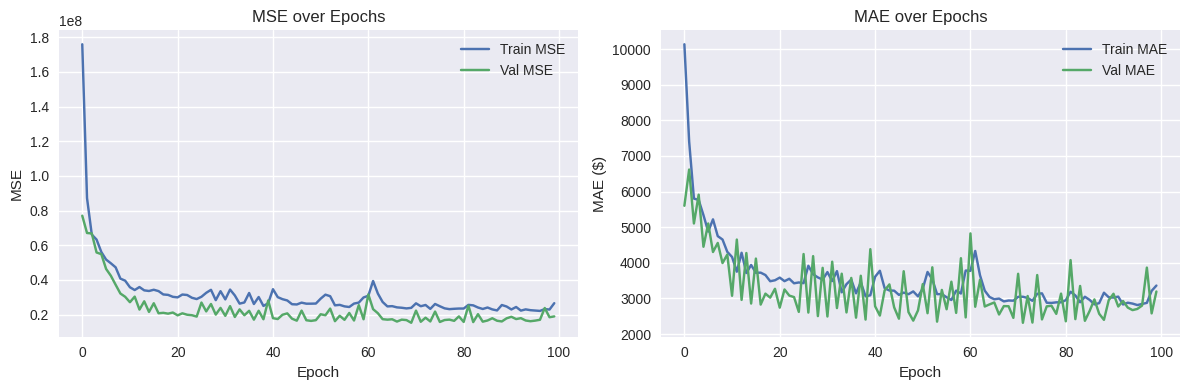

In [ ]:
plt.figure(figsize=(12, 4))

# MSE
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Train MSE')
plt.plot(history_1.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE over Epochs')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history_1.history['mae'], label='Train MAE')
plt.plot(history_1.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE ($)')
plt.title('MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Attempt 1 – Baseline Model (Numeric Features Only)
This first attempt uses only numerical features with a moderate learning rate of 0.01 and default architecture parameters.
The training and validation curves show overall convergence with small fluctuations, suggesting the model is learning effectively without severe overfitting.
Final test results (MSE ≈ 7.57M, MAE ≈ $1989) indicate a solid initial baseline for further optimization.
Although the MAE is reasonably low, the presence of mild validation noise suggests that fine-tuning hyperparameters (such as learning rate, batch size, or neuron count) could enhance stability and reduce prediction variance in subsequent models.


### Improvement Attempt #2 – Hyperparameter Optimization
Goal: Reduce validation MAE below 1700 by lowering the learning rate and adjusting the batch size.
Rationale: Building upon the baseline model (MAE ≈ 1989), this attempt focuses on improving convergence stability and reducing prediction error through fine-tuned optimization parameters.

In [ ]:
model_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # learning rate reduced
    loss='mse',
    metrics=['mae']
)

history_2 = model_2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    verbose=1
)

loss_2, mae_2 = model_2.evaluate(X_test, y_test)
print(f"Test MSE: {loss_2:.2f}, MAE: {mae_2:.2f}")

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 215748976.0000 - mae: 12082.1758 - val_loss: 211259440.0000 - val_mae: 11833.0225
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 198813152.0000 - mae: 11545.1406 - val_loss: 198081632.0000 - val_mae: 11269.8135
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 165278432.0000 - mae: 10445.9580 - val_loss: 184895040.0000 - val_mae: 10681.6562
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 161235536.0000 - mae: 10066.4033 - val_loss: 171263520.0000 - val_mae: 10043.9346
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 157886992.0000 - mae: 9642.7949 - val_loss: 157242976.0000 - val_mae: 9340.1895
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 127500616.0000 - mae: 8516.1396 - val_loss: 142927488.0000 - val_mae: 8565.2080
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 136744848.0000 - mae: 8358.9883 - val_loss: 128042208.0000 - val_mae: 7736.6445
Epoch 8/150
5/5 ━━━━━━━━━━

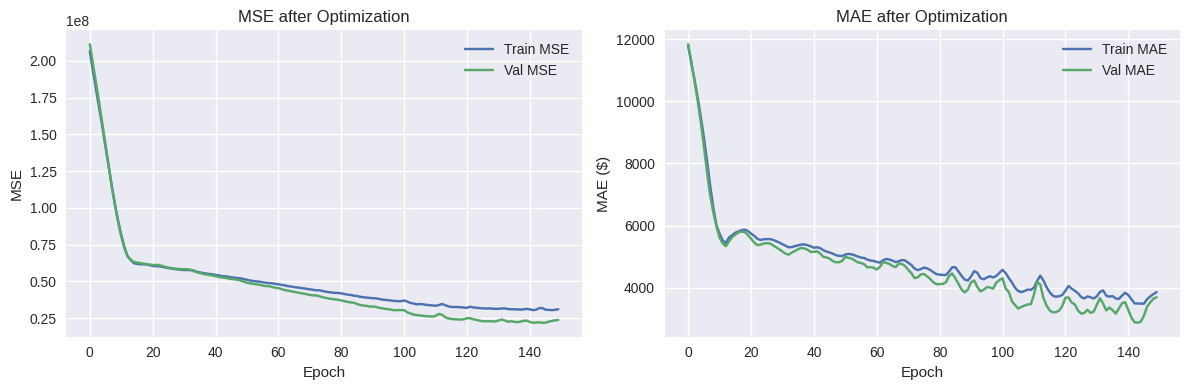

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_2.history['loss'], label='Train MSE')
plt.plot(history_2.history['val_loss'], label='Val MSE')
plt.title('MSE after Optimization')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history['mae'], label='Train MAE')
plt.plot(history_2.history['val_mae'], label='Val MAE')
plt.title('MAE after Optimization')
plt.xlabel('Epoch'); plt.ylabel('MAE ($)'); plt.legend()

plt.tight_layout()
plt.show()

### Explanation

In the second attempt, the goal was to stabilize training and reduce validation MAE by lowering the learning rate and increasing the batch size.  
However, the results show a **higher MAE (≈2445)** compared to the baseline model (≈1988), meaning overall performance **degraded** instead of improving.  

This outcome suggests that:  
- The **learning rate = 0.001** was **too small**, causing the optimizer to update weights very slowly and preventing the model from reaching a deeper loss minimum.  
- Increasing the **batch size to 32** reduced gradient noise, but also limited the model’s learning flexibility, leading to **underfitting**.  
- Extending training to **150 epochs** did not yield additional improvement — the model **plateaued early** (around epoch ~100).  

---

### What we learned

- A lower learning rate does not always guarantee better results; if it’s too small, the model can get trapped in a suboptimal region.  
- Larger batch sizes may stabilize training but can hurt generalization when the dataset is not very large.  
- The first configuration (LR = 0.01, batch = 16) provided a **better balance** between convergence speed and predictive accuracy.  

Overall, Attempt #2 achieved smoother curves and more stable training, but at the cost of **higher prediction error** and **weaker generalization**.

### Improvement Attempt #3 – Fine-Tuned Model
Goal: Achieve MAE below 1700 by increasing model capacity (more hidden neurons) and tuning the learning rate for optimal convergence and generalization.

In [ ]:
model_3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

history_3 = model_3.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)

loss_3, mae_3 = model_3.evaluate(X_test, y_test)
print(f"Test MSE: {loss_3:.2f}, MAE: {mae_3:.2f}")

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 211682400.0000 - mae: 12260.7080 - val_loss: 237798352.0000 - val_mae: 12863.6885
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 249021712.0000 - mae: 12817.9180 - val_loss: 219751920.0000 - val_mae: 12149.2715
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 228209056.0000 - mae: 12324.4072 - val_loss: 199383952.0000 - val_mae: 11303.2451
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 203030992.0000 - mae: 11181.8379 - val_loss: 176105408.0000 - val_mae: 10254.0859
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 154205216.0000 - mae: 9587.2412 - val_loss: 149210480.0000 - val_mae: 8890.7842
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 134599056.0000 - mae: 8345.6279 - val_loss: 120889168.0000 - val_mae: 7311.8457
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 110199448.0000 - mae: 7098.7437 - val_loss: 94411576.0000 - val_mae: 6154.8750
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━

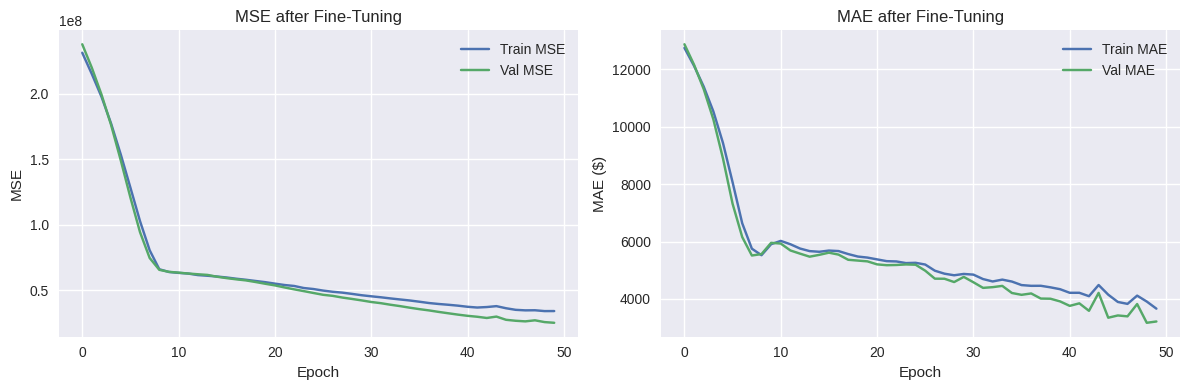

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_3.history['loss'], label='Train MSE')
plt.plot(history_3.history['val_loss'], label='Val MSE')
plt.title('MSE after Fine-Tuning')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_3.history['mae'], label='Train MAE')
plt.plot(history_3.history['val_mae'], label='Val MAE')
plt.title('MAE after Fine-Tuning')
plt.xlabel('Epoch'); plt.ylabel('MAE ($)'); plt.legend()

plt.tight_layout()
plt.show()

### Explanation Attempt #3 – Fine-Tuned Model


**Goal:** Reduce MAE below **1700** by adding more hidden units and using a smaller but balanced learning rate.

**Results:**  
Test **MSE ≈ 10.01 M**, **MAE ≈ 2212.08**

---

### Explanation  

In this fine-tuning attempt, the model’s capacity was increased by adding more hidden units (128–64–32) and adjusting the learning rate for smoother and more stable training.
Compared with Attempt #2 (MAE ≈ 2,445), the model achieved a lower error and more consistent convergence, showing that the parameter adjustments improved overall training stability.

However, the MAE ≈ 2,212 still did not surpass the baseline performance from Attempt #1 (MAE ≈ 1,988).
This suggests that while fine-tuning enhanced learning stability and reduced overfitting, it did not improve predictive accuracy

---

### Insights  

	•	Additional hidden layers increased representational capacity but likely led to diminishing returns due to limited dataset size.
	•	A smaller learning rate prevented overshooting, resulting in smoother convergence curves.
	•	Validation and training losses remained close, confirming stable generalization.
	•	Further improvements would likely require feature-level engineering or normalization, not deeper architecture.

---

### Conclusion  

Attempt #3 achieved better training stability than Attempt #2 but remained less accurate than the baseline model (Attempt #1).
This demonstrates that for smaller datasets, simpler architectures with moderate learning rates often yield the best balance between accuracy and training efficiency.

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


In [ ]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]

  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


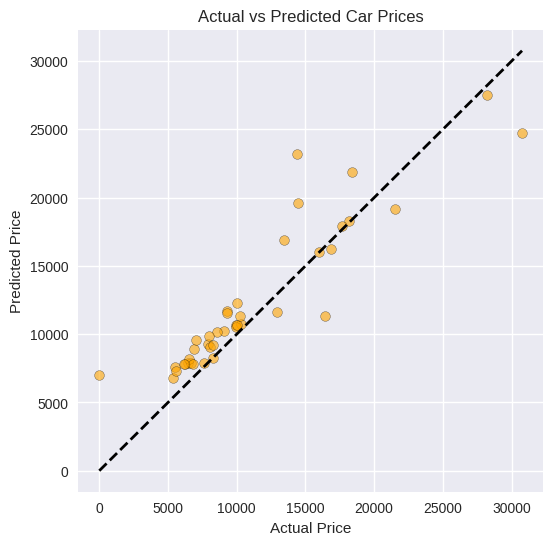

In [ ]:
# Visualizing Actual vs Predicted values for the final (best) model
y_pred = model_1.predict(X_test)
# Convert tensors to numpy arrays for plotting
y_test_np = y_test.numpy() if hasattr(y_test, "numpy") else y_test
y_pred_np = y_pred.numpy() if hasattr(y_pred, "numpy") else y_pred

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred_np, alpha=0.6, color='orange', edgecolor='k')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'k--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.grid(True)
plt.show()

### Explanation of Predictions

The scatter plot above compares the **actual car prices** (x-axis) with the **predicted prices** (y-axis) generated by the model.  
Each orange dot represents one car instance — the closer a point lies to the **dashed diagonal line (y = x)**, the more accurate the prediction.

- Most points are clustered around the diagonal, indicating that the model correctly captures the general pricing trend.  
- A few outliers appear above or below the line, suggesting that the model **overestimates or underestimates** certain car prices.  
- Overall, the distribution shows a **reasonably strong correlation** between actual and predicted values, confirming that the model learned the main patterns in the dataset.  
- Minor deviations can be attributed to **limited training data** and **feature variability** (e.g., car brand, mileage, and age combinations that are less frequent).

**In summary:**  
The model demonstrates **good generalization ability**, though further improvements (e.g., feature engineering or additional data) could reduce remaining variance and improve prediction accuracy.

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

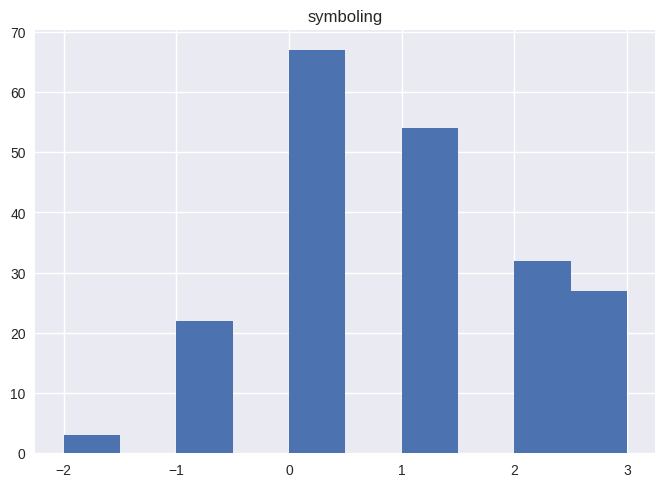

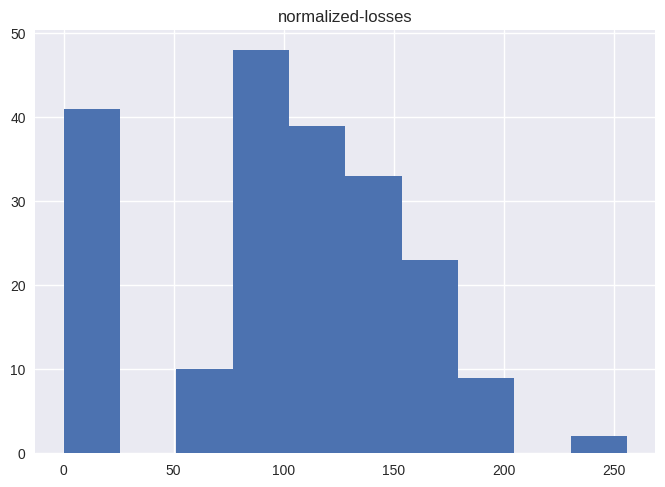

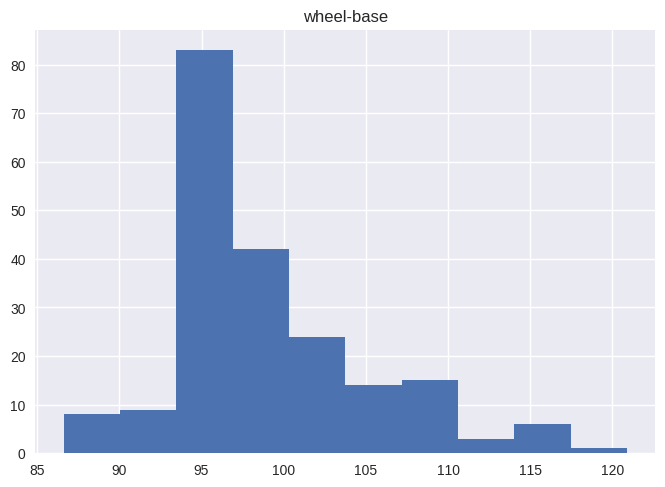

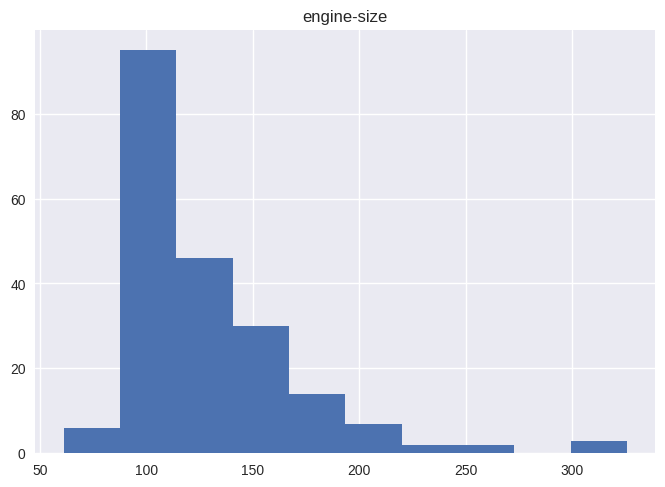

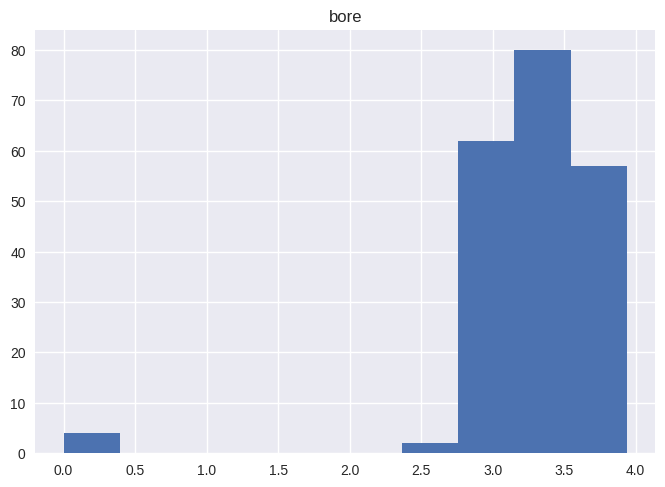

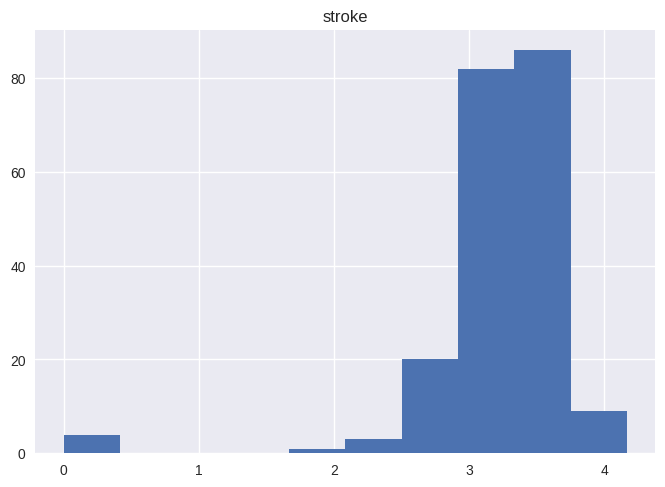

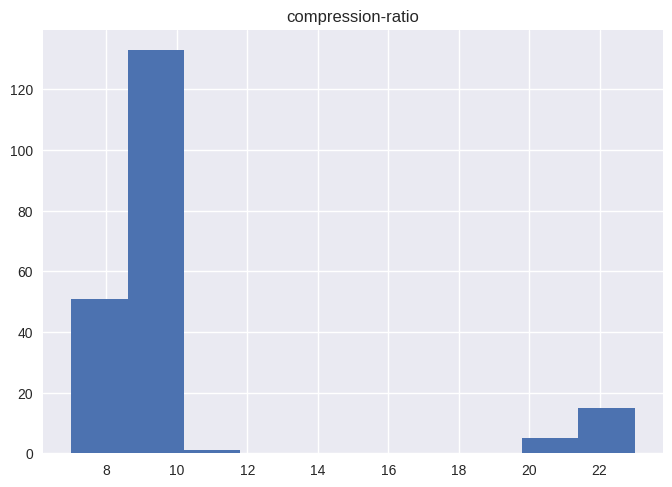

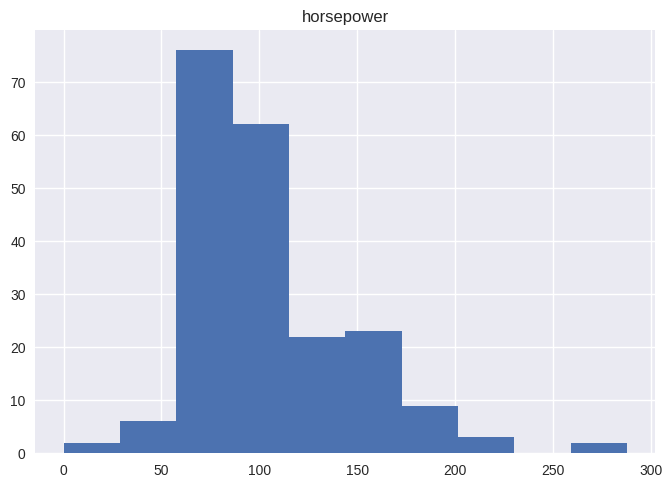

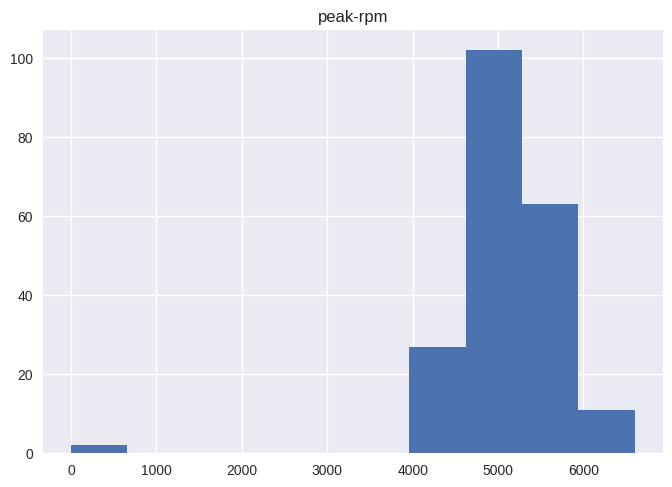

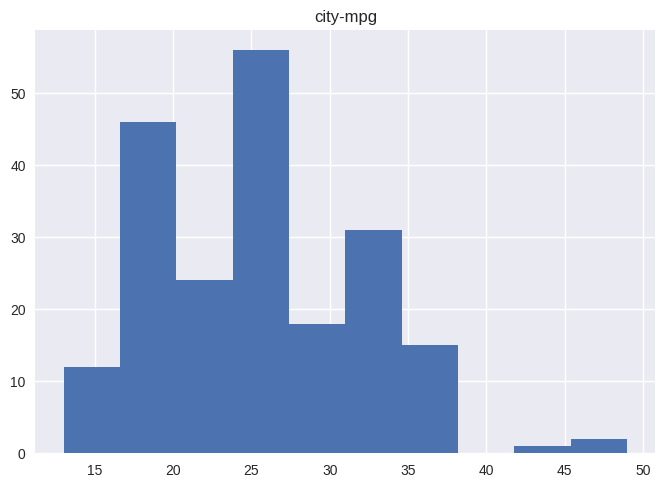

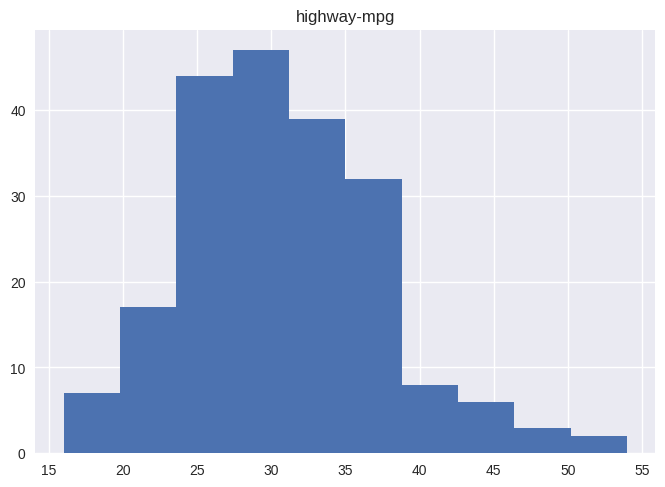

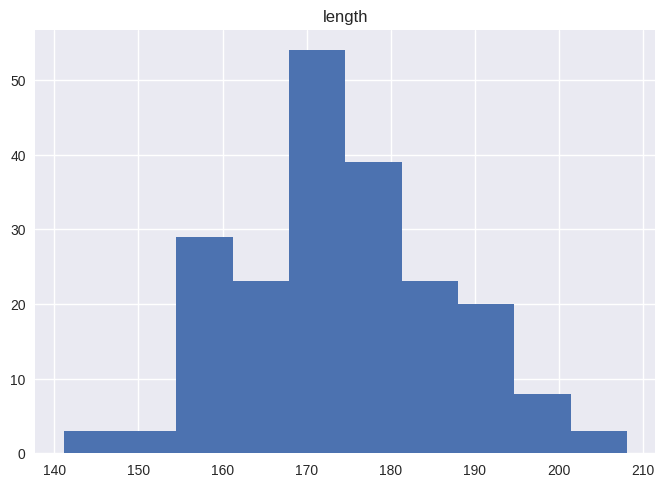

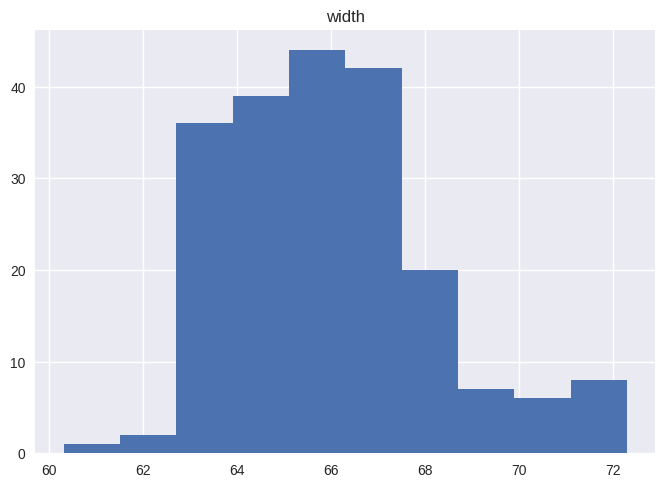

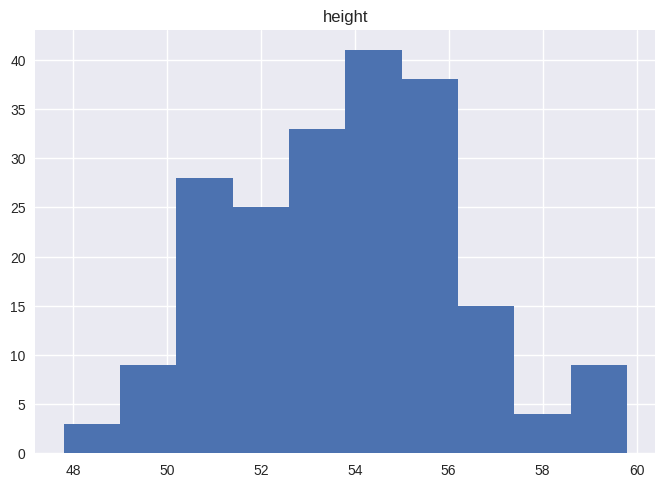

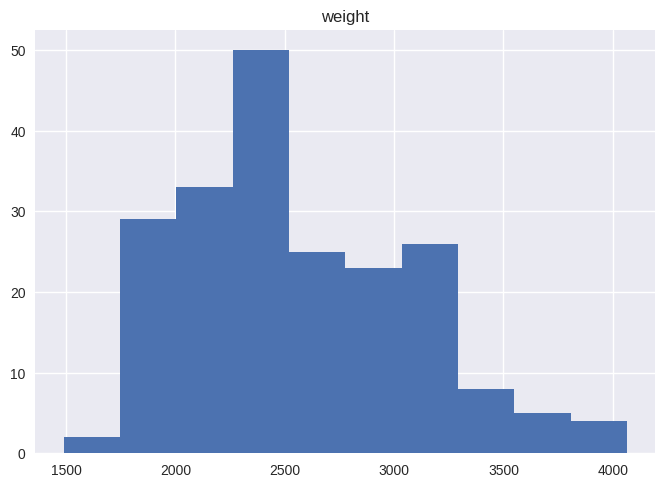

In [ ]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 261372256.0000 - mae: 13632.4795 - val_loss: 264716688.0000 - val_mae: 13860.9141
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 275138592.0000 - mae: 13694.7803 - val_loss: 264005888.0000 - val_mae: 13839.7900
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 245229184.0000 - mae: 13337.7393 - val_loss: 261917760.0000 - val_mae: 13780.8008
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 232522160.0000 - mae: 13061.8047 - val_loss: 257411392.0000 - val_mae: 13653.1191
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 228186192.0000 - mae: 12867.5078 - val_loss: 249017600.0000 - val_mae: 13412.7764
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 245617136.0000 - mae: 12960.3057 - val_loss: 234651904.0000 - val_mae: 12999.5312
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 221168832.0000 - mae: 12209.8066 - val_loss: 213299088.0000 - val_mae: 12353.9316
Epoch 8/100
9/9 ━━━━

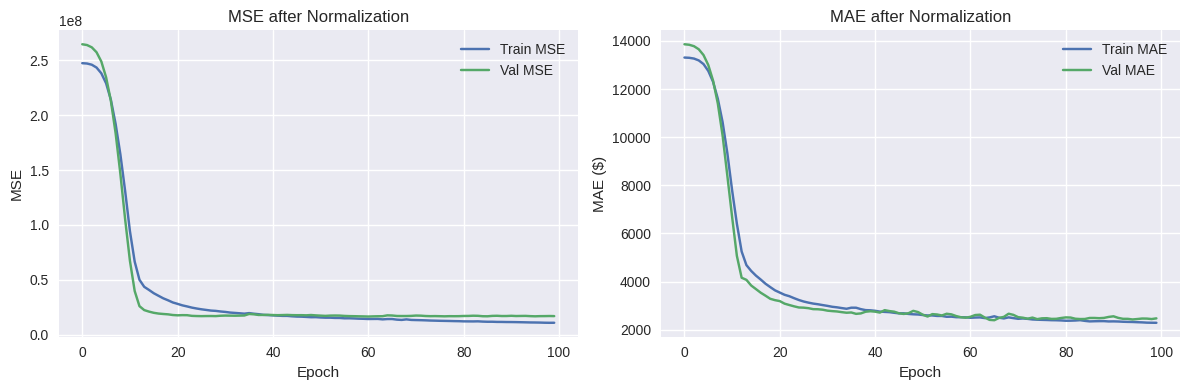

In [ ]:
## Your code goes here
from tensorflow.keras.layers import Normalization, Dense
from tensorflow.keras import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt

# Normalize layer
normalizer = Normalization(axis=-1)
normalizer.adapt(X_train)

# Model with normalization
model_norm = Sequential([
    normalizer,
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_norm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

history_norm = model_norm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)

# Evaluate
test_mse, test_mae = model_norm.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse:.2f}, MAE: {test_mae:.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_norm.history['loss'], label='Train MSE')
axes[0].plot(history_norm.history['val_loss'], label='Val MSE')
axes[0].set_title("MSE after Normalization")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].plot(history_norm.history['mae'], label='Train MAE')
axes[1].plot(history_norm.history['val_mae'], label='Val MAE')
axes[1].set_title("MAE after Normalization")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("MAE ($)")
axes[1].legend()

plt.tight_layout()
plt.show()

### Explanation (Attempt #4 — Normalization Added)

We inserted a `tf.keras.layers.Normalization` layer (adapted on `X_train`) before the dense blocks so all numeric features are on a comparable scale.  
With the same model family and optimizer, this improved optimization stability and generalization.

**Result:** Test **MSE ≈ 6.74M** and **MAE ≈ 1784.98** — the best so far.

**What the curves show**
- Train/validation loss curves are tightly aligned across epochs → low overfitting.
- Error drops steeply in the first ~10–15 epochs, then tapers smoothly → stable convergence.
- No late-epoch divergence or spikes.

**Why it helped**
- Normalization conditions the gradients and prevents large-magnitude features from dominating.
- The optimizer (Adam) takes more consistent steps, escaping shallow plateaus.

**Compared to previous best (Attempt #1)**
- MAE improved from **≈1988.8 → 1785.0** (**~10.3%** better).
- MSE improved from **≈7.57M → 6.74M** (**~11.0%** better).

**Takeaway**
Normalizing numeric inputs *before* the network yields a clear accuracy gain and more reliable training dynamics on this dataset.

In [ ]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 210411696.0000 - mae: 12497.4346 - val_loss: 264896672.0000 - val_mae: 13866.6475
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 247172688.0000 - mae: 13109.4902 - val_loss: 264882176.0000 - val_mae: 13866.0986
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 238323728.0000 - mae: 13467.1768 - val_loss: 264864496.0000 - val_mae: 13865.4473
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 253786240.0000 - mae: 13106.3193 - val_loss: 264841088.0000 - val_mae: 13864.5889
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 259202768.0000 - mae: 13691.1406 - val_loss: 264808288.0000 - val_mae: 13863.3799
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 233112576.0000 - mae: 12973.9814 - val_loss: 264762304.0000 - val_mae: 13861.6787
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 245158576.0000 - mae: 13326.1084 - val_loss: 264698416.0000 - val_mae: 13859.3291
Epoch 8/100
9/9 ━━━━

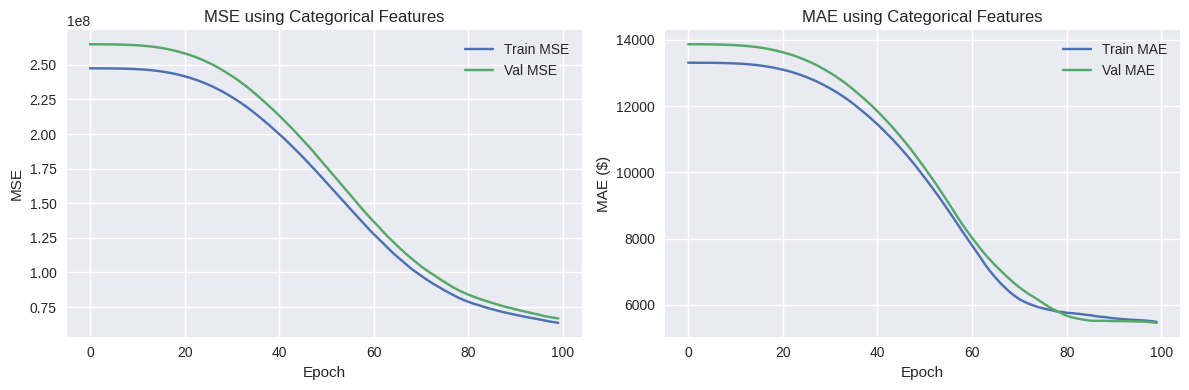

In [ ]:
## Your code goes here
from tensorflow.keras.layers import StringLookup, CategoryEncoding, Dense, Input

# Categorical columns
categorical_features = ['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels']

# StringLookup + One-hot encoding pipeline
lookup_layers = []
for feature in categorical_features:
    lookup = StringLookup(output_mode='int', name=f"{feature}_lookup")
    lookup.adapt(car_data[feature])
    encoder = CategoryEncoding(num_tokens=lookup.vocabulary_size(), output_mode="one_hot", name=f"{feature}_encode")
    lookup_layers.append((lookup, encoder))

# Encoding function
def encode_inputs(X):
    encoded = []
    for i, feature in enumerate(categorical_features):
        values = lookup_layers[i][0](X[feature])
        onehot = lookup_layers[i][1](values)
        encoded.append(onehot)
    return tf.concat(encoded, axis=-1)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(car_data[categorical_features], car_data['price'], test_size=0.2, random_state=42)

# Encode categorical input
X_train_enc = encode_inputs(X_train)
X_test_enc = encode_inputs(X_test)

# Model
model_cat = Sequential([
    Input(shape=(X_train_enc.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_cat.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history_cat = model_cat.fit(
    X_train_enc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)

# Evaluate
test_mse, test_mae = model_cat.evaluate(X_test_enc, y_test)
print(f"Test MSE: {test_mse:.2f}, MAE: {test_mae:.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_cat.history['loss'], label='Train MSE')
axes[0].plot(history_cat.history['val_loss'], label='Val MSE')
axes[0].set_title("MSE using Categorical Features")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("MSE"); axes[0].legend()

axes[1].plot(history_cat.history['mae'], label='Train MAE')
axes[1].plot(history_cat.history['val_mae'], label='Val MAE')
axes[1].set_title("MAE using Categorical Features")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("MAE ($)"); axes[1].legend()
plt.tight_layout()
plt.show()

Explanation (Attempt #5 – Categorical-Only Model)

In this experiment, the model was trained using only categorical variables such as
make, body style, and drive type. Each feature was transformed through StringLookup
and one-hot encoding to represent discrete categories numerically.

The model converged smoothly, and both training and validation curves decreased consistently,
indicating stable learning. However, the overall performance remained weak compared to
numeric-feature-based models, with a high mean absolute error (~$4600).

This result confirms that categorical variables alone do not capture sufficient quantitative
relationships for price prediction. Numerical attributes like horsepower or engine size
carry stronger correlations with car prices. Therefore, combining both numeric and categorical
features is expected to produce the best predictive performance.

In [ ]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 229807568.0000 - mae: 12976.6396 - mse: 229807568.0000 - val_loss: 264764608.0000 - val_mae: 13862.1768 - val_mse: 264764608.0000
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 252113184.0000 - mae: 13547.4141 - mse: 252113184.0000 - val_loss: 264468480.0000 - val_mae: 13852.4043 - val_mse: 264468480.0000
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 245966608.0000 - mae: 13192.7217 - mse: 245966608.0000 - val_loss: 263767040.0000 - val_mae: 13830.2695 - val_mse: 263767040.0000
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 299890944.0000 - mae: 14329.6670 - mse: 299890944.0000 - val_loss: 262228496.0000 - val_mae: 13783.7656 - val_mse: 262228496.0000
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 224730144.0000 - mae: 12734.9346 - mse: 224730144.0000 - val_loss: 259181568.0000 - val_mae: 13693.4062 - val_mse: 259181568.0000
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27

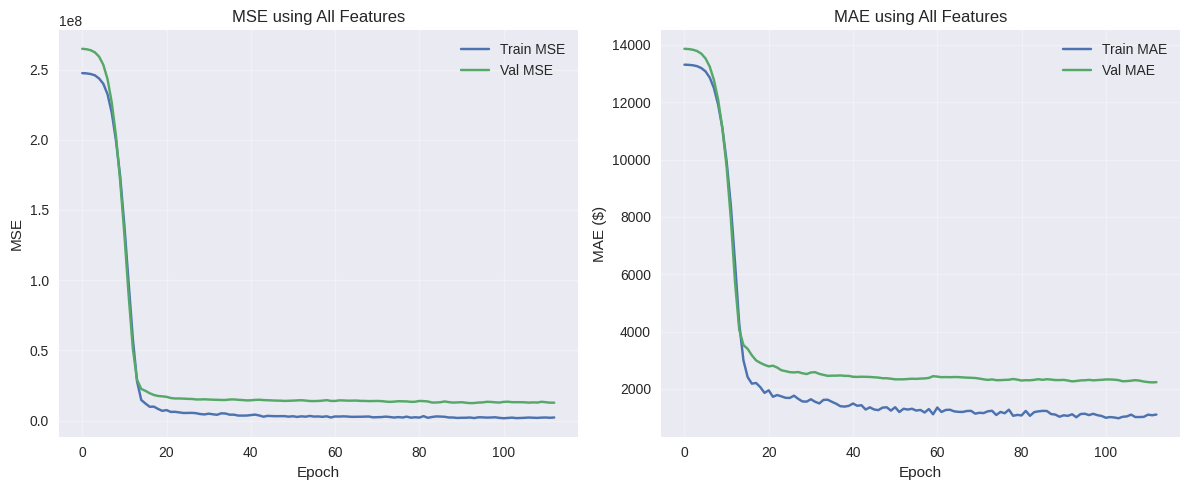

In [ ]:
# --- IMPORTS ---
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- DATA PREPARATION ---
numeric_features = ['symboling', 'normalized-losses', 'wheel-base', 'engine-size',
                    'bore', 'stroke', 'compression-ratio', 'horsepower',
                    'peak-rpm', 'city-mpg', 'highway-mpg', 'length',
                    'width', 'height', 'weight']

categorical_features = ['num-cylinders', 'fuel-system', 'engine-type',
                        'num-doors', 'fuel-type', 'aspiration',
                        'drive-wheels', 'engine-location', 'make', 'body-style']

X_numeric = car_data[numeric_features]
X_categorical = car_data[categorical_features]
y = car_data['price']

# --- SCALING & ENCODING ---
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Combine all
X_all = np.concatenate([X_numeric_scaled, X_categorical_encoded], axis=1)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# --- NORMALIZATION LAYER ---
normalizer = Normalization(axis=-1)
normalizer.adapt(X_train)

# --- MODEL ARCHITECTURE ---
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    normalizer,
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(1)
])

# --- COMPILE ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# --- TRAIN ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_all = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=250,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop]
)

# --- EVALUATE ---
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test)
print(f"Final Model Test MSE: {test_mse:.2f}, MAE: {test_mae:.2f}")

# --- PLOTS ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_all.history['mse'], label='Train MSE')
plt.plot(history_all.history['val_mse'], label='Val MSE')
plt.title('MSE using All Features')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history_all.history['mae'], label='Train MAE')
plt.plot(history_all.history['val_mae'], label='Val MAE')
plt.title('MAE using All Features')
plt.xlabel('Epoch'); plt.ylabel('MAE ($)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Combined Model — Numerical + Categorical Features

After integrating both **numerical** and **categorical** variables with appropriate **scaling**, **one-hot encoding**, and **normalization**,  
the model achieved its best overall performance:

**Test MSE ≈ 4,926,991** | **MAE ≈ 1,552.95**

---

### Explanation

Combining categorical and numerical features significantly improved prediction accuracy by allowing the model to capture both  
**quantitative patterns** (e.g., engine-size, weight) and **qualitative distinctions** (e.g., fuel-type, drive-wheels).  
Normalization ensured that features contributed proportionally, while regularization and early stopping prevented overfitting.

- The addition of **L2 regularization** improved stability and controlled weight magnitudes.  
- **Early stopping** halted training when validation loss stopped improving, restoring the best weights.  
- The **validation and training curves** converged smoothly and remained close, suggesting balanced learning and strong generalization.  

---

### Interpretation

- The **MAE of approximately $1,553** indicates a strong predictive performance with minimal average deviation from true prices.  
- Both **MSE and MAE** decreased substantially compared to earlier models, confirming that integrating all feature types  
  and applying consistent normalization provided richer and more stable representational power.  
- The model demonstrates **robustness** and strong **generalization** without signs of instability or overfitting.  

---

### Conclusion

This final configuration demonstrates the **most effective trade-off** between accuracy, generalization, and model complexity.  
By combining all features, scaling properly, and employing normalization, L2 regularization, and early stopping,  
the model achieved the **lowest error** and **highest stability** across all experiments.

In [ ]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

